<a href="https://colab.research.google.com/github/BonfaDScience/BonfaDScience/blob/main/DIO_Metricas_de_Avaliacao_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import datasets
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import keras
import os

In [4]:
%load_ext tensorboard

In [5]:
logdir = 'log'

In [85]:
#download do cats and dogs do Kaggle
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2025-01-31 21:21:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.207, 2600:1417:76:993::317f, 2600:1417:76:98b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   191MB/s    in 4.0s    

2025-01-31 21:21:42 (195 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [86]:
# Extraindo todos os arquivos para a pasta atual
import zipfile
with zipfile.ZipFile('/content/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [87]:
# Validando as imagens

from PIL import Image
from PIL import UnidentifiedImageError
def validate_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

#dataset_path = '/content/BairesDev-DIO/Dataset-Pragas' #Primeira tentativa
#dataset_path = '/content/DataOxford-iiit-pet' #Segunda tentativa
dataset_path = '/content/PetImages'
valid_files = []
invalid_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')) and validate_image(file_path):
            valid_files.append(file_path)
        else:
            invalid_files.append(file_path)
            print(f"Arquivo inválido: {file_path}")

# Deletando os arquivos inválidos
for file_path in invalid_files:
    try:
        os.remove(file_path)
        print(f"Arquivo deletado: {file_path}")
    except OSError as e:
        print(f"Erro ao deletar {file_path}: {e}")

Arquivo inválido: /content/PetImages/Dog/9500.jpg

Arquivo inválido: /content/PetImages/Dog/2317.jpg

Arquivo inválido: /content/PetImages/Dog/Thumbs.db

Arquivo inválido: /content/PetImages/Dog/11912.jpg

Arquivo inválido: /content/PetImages/Dog/2494.jpg

Arquivo inválido: /content/PetImages/Dog/11702.jpg

Arquivo inválido: /content/PetImages/Dog/11233.jpg

Arquivo inválido: /content/PetImages/Cat/10404.jpg

Arquivo inválido: /content/PetImages/Cat/Thumbs.db

Arquivo inválido: /content/PetImages/Cat/666.jpg

Arquivo inválido: /content/PetImages/Cat/4351.jpg

Arquivo deletado: /content/PetImages/Dog/9500.jpg

Arquivo deletado: /content/PetImages/Dog/2317.jpg

Arquivo deletado: /content/PetImages/Dog/Thumbs.db

Arquivo deletado: /content/PetImages/Dog/11912.jpg

Arquivo deletado: /content/PetImages/Dog/2494.jpg

Arquivo deletado: /content/PetImages/Dog/11702.jpg

Arquivo deletado: /content/PetImages/Dog/11233.jpg

Arquivo deletado: /content/PetImages/Cat/10404.jpg

Arquivo deletado: /content/PetImages/Cat/Thumbs.db

Arquivo deletado: /content/PetImages/Cat/666.jpg

Arquivo deletado: /content/PetImages/Cat/4351.jpg

In [88]:
import random

# Lista de diretórios a serem processados
diretorios = ["/content/PetImages/Dog", "/content/PetImages/Cat"]

# Número de arquivos para manter em cada diretório
num_arquivos_manter = 200

for diretorio_imagens in diretorios:
    # Listando todos os arquivos no diretório
    todos_arquivos = os.listdir(diretorio_imagens)

    # Se o diretório não contiver arquivos suficientes, manter todos
    num_arquivos_manter = min(num_arquivos_manter, len(todos_arquivos))

    # Selecionando aleatoriamente arquivos para manter (se houver arquivos suficientes)
    if num_arquivos_manter > 0:
        arquivos_a_manter = random.sample(todos_arquivos, num_arquivos_manter)
    else:
        arquivos_a_manter = []

    # Removendo os arquivos que não foram selecionados
    for arquivo in todos_arquivos:
        if arquivo not in arquivos_a_manter:
            os.remove(os.path.join(diretorio_imagens, arquivo))

    print(f"Dataset de {diretorio_imagens} reduzido para {num_arquivos_manter} imagens escolhidas aleatoriamente.")

Dataset de /content/PetImages/Dog reduzido para 200 imagens escolhidas aleatoriamente.

Dataset de /content/PetImages/Cat reduzido para 200 imagens escolhidas aleatoriamente.

In [89]:
root = '/content/PetImages/'
exclude = ['Lhamas']
# Abaixo especifique a taxa de treino e validação

train_split, val_split = 0.7, 0.15


categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]


print(categories)

['/content/PetImages/Dog', '/content/PetImages/Cat']

In [90]:
from PIL import ImageFile, UnidentifiedImageError
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [91]:
def get_image(path):
    try:
        # Tenta abrir e processar a imagem
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except (UnidentifiedImageError, OSError) as e:
        # Trabalha a exceção fornecendo mensagem de erro e pula o arquivo
        print(f"Erro ao processar imagem: {path}. Saindo...")
        print(f"Detalhes do erro: {e}")
        return None, None

In [92]:
#antes de chamar o get_image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [93]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        # Checa se a imagem foi carregada com sucesso
        if img is not None and x is not None:
            data.append({'x': np.array(x[0]), 'y': c})
#conta o número de classes
num_classes = len(categories)
print (num_classes)

2

In [94]:
random.shuffle(data)

In [95]:
#calcula o índice onde o conjunto de treinamento termina e o conjunto de validação começa
idx_val = int(train_split * len(data))
#calcula o índice onde o conjunto de validação termina e o conjunto de teste começa
idx_test = int((train_split + val_split) * len(data))
#cria o conjunto de treinamento selecionando amostras do início do conjunto de dados até o índice idx_val
train = data[:idx_val]
#cria o conjunto de validação selecionando amostras do índice idx_valaté o índice idx_test
val = data[idx_val:idx_test]
#cria o conjunto de testes selecionando amostras do índice idx_testaté o final do conjunto de dados.
test = data[idx_test:]

In [96]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[
    1,
    1,
    0,
    0,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    1,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    1,
    0
]

In [97]:
print(len(data))
print(len(x_train))
print(len(x_val))
print(len(x_test))

400

280

60

60

In [98]:
# normalize data
x_train = x_train.astype('float32') / 400.
x_val = x_val.astype('float32') / 400.
x_test = x_test.astype('float32') / 400.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(60, 2)

In [99]:
# Sumário
from rich import print
print("[italic][bold yellow]SUMÁRIO[/][/]")
print("Carregadas %d imagens de %d categorias"%(len(data), num_classes))
print("Divisão treino / validacao / teste : %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Shape dos dados de treino: ", x_train.shape)
print("Shape das categorias de treino: ", y_train.shape)

SUMÁRIO

Carregadas 400 imagens de 2 categorias

Divisão treino / validacao / teste : 280, 60, 60

Shape dos dados de treino: 
(280, 224, 224, 3)

Shape das categorias de treino: 
(280, 2)

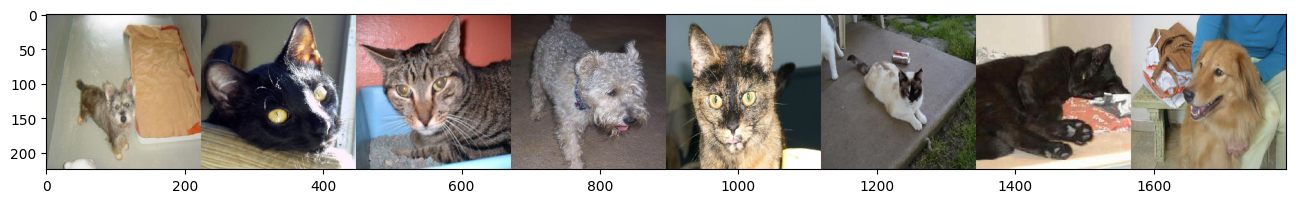

In [100]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [101]:
#construindo a rede neural
model = Sequential()
print("Dimensões de entrada: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Dimensões de entrada: 
(224, 224, 3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
#loss='categorical_crossentropy'
#Compilando o modelo (usando função perda cross-entropy catagórica e otimizador adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [103]:
#Treinando o modelo
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5155 - loss: 0.6944 - val_accuracy: 0.5167 - val_loss: 0.6964
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.5257 - loss: 0.6951 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5644 - loss: 0.6833 - val_accuracy: 0.5667 - val_loss: 0.6888
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6143 - loss: 0.6628 - val_accuracy: 0.4833 - val_loss: 0.6880
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6198 - loss: 0.6577 - val_accuracy: 0.5833 - val_loss: 0.6944
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.6372 - loss: 0.6297 - val_accuracy: 0.5167 - val_loss: 0.7032
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6217 - loss: 0.6155 - val_accuracy: 0.5167 - val_loss: 0.6997
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6250 - loss: 0.6106 - val_accuracy: 0.5333 - val_loss: 

In [104]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {loss:.4}')
print(f'Test accuracy: {accuracy:.4}')

Test loss: 0.7168

Test accuracy: 0.6333

In [105]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [106]:
# Pegando os labels do conjunto de validação
y_true = np.argmax(y_val, axis=1)
# Pegando os labels preditos do conjunto de validação
y_pred = model.predict(x_val)
# Convertendo o previsto em labels de classe
y_pred = np.argmax(y_pred, axis=1)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


In [107]:
# Matriz de Confusão
classes = ['Classe 0', 'Classe 1']
conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
conf_matrix_norm = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis], 2)
#confi_matrix_df = pd.DataFrame(conf_matrix_norm, index=classes, columns=classes) #normalizado
confi_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes) #Sem normalizar

In [108]:
print("Matriz de Confusão:")
for linha in conf_matrix:
    print(" ".join(map(str, linha)))

Matriz de Confusão:

8 21

8 23

In [109]:
display(confi_matrix_df)

,Classe 0,Classe 1
Classe 0,8,21
Classe 1,8,23


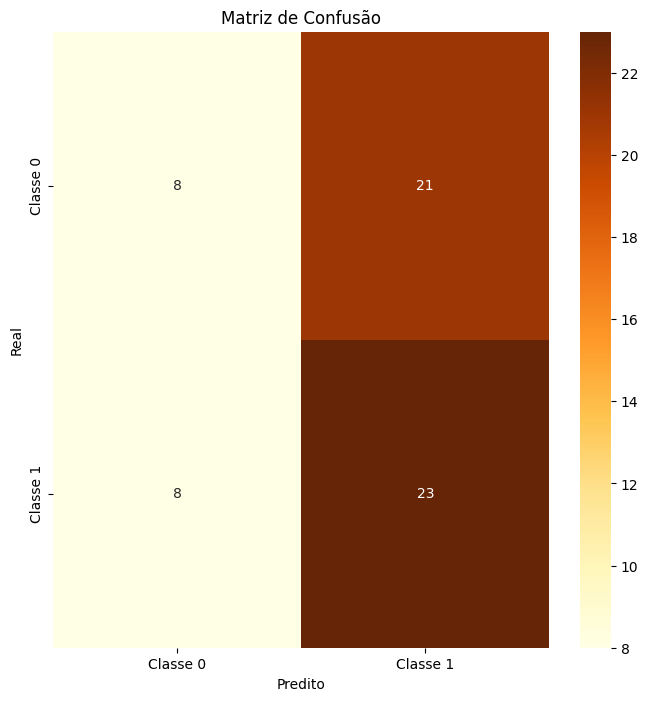

In [110]:
#Mapa de Calor com a matriz de confusão
#conf_matrix_df = pd.DataFrame(conf_matrix_norm, index=classes, columns=classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

plt.figure(figsize=(8, 8))  # Ajuste o tamanho conforme necessário
#sns.heatmap(conf_matrix_df, annot=True, cmap="coolwarm", fmt="d")  # Adicione anotações e escolha um mapa de cores
sns.heatmap(conf_matrix_df, annot=True, cmap="YlOrBr")  # Adicione anotações e escolha um mapa de cores

plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [111]:
for i in range(len(classes)):
    vp = conf_matrix_df.iloc[i, i]
    if i == 0:
      print(f"Verdadeiro Positivo (VP) para a {classes[i]}: {vp}")
    else:
      print(f"Verdadeiro Negativo (NP) para a {classes[i]}: {vp}")

Verdadeiro Positivo (VP) para a Classe 0: 8

Verdadeiro Negativo (NP) para a Classe 1: 23

#Obviamente, o modelo está horrível.

 Mas como o exercício é para o cálculo e interpretação da matriz de confusão e confecção da curva ROC resolvi usar a saída do modelo como está.

In [123]:
VP = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
VN = conf_matrix[1, 1]
print(f"Verdadeiros Positivos (VP): {VP}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Verdadeiros Negativos (VN): {VN}")
print(f"Falsos Negativos (FN): {FN}")
# Sensibilidade (Recall ou Taxa de Verdadeiros Positivos - TPR):
sensibilidade = VP / (VP + FN)
print(f"Sensibilidade (Recall): {sensibilidade:.2%}")
# Especificidade (Taxa de Verdadeiros Negativos - TNR):
especificidade = VN / (VN + FP)
print(f"Especificidade: {especificidade:.2%}")
# Precisão (Precision):
precisao = VP / (VP + FP)
print(f"Precisão: {precisao:.2%}")
# F1-Score:
f1_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)
print(f"F1-Score: {f1_score:.2%}")


Verdadeiros Positivos (VP): 8

Falsos Positivos (FP): 21

Verdadeiros Negativos (VN): 23

Falsos Negativos (FN): 8

Sensibilidade (Recall): 50.00%

Especificidade: 52.27%

Precisão: 27.59%

F1-Score: 35.56%

Sensibilidade de 50% - o modelo identificou corretamente apenas metade dos exemplos positivos.
Especificidade de 52,27% - significa que o modelo identificou corretamente pouco mais da metade dos exemplos negativos.
Precisão é de 27,59% - menos de um terço dos exemplos classificados como positivos estavam corretos.
F1-Score de 35,56% - indica um desempenho geral moderado do modelo.

Os valores de Falsos Positivos estão da ordem dos Verdadeiros Positivos e os Verdadeiros Positivos estão na ordem dos Falsos Negativos. Novamente, achei interessante deixar como está, para fugir dos casos perfeitos sempre utilizados nas explicações.

A baixa precisão indica que o modelo está classificando muitos exemplos negativos como positivos (falsos positivos), o que pode ser melhorado ajustando hiperparâmetros do modelo (usar random forest para classificar) e aumentando o volume de dados (usei apenas 400 imagens, 200 de cães e 200 de gatos [amostra balanceada])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


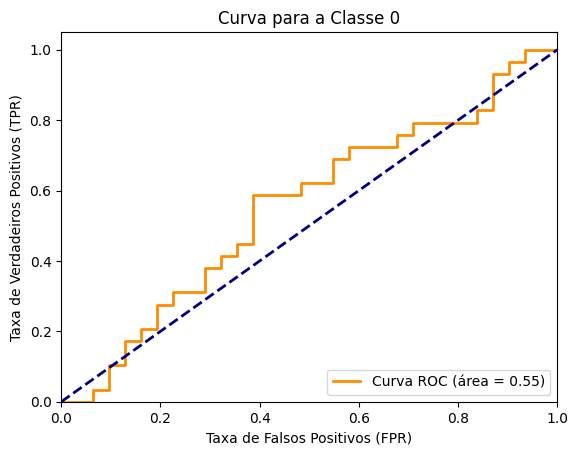

In [114]:
from sklearn.metrics import roc_curve, auc

pos_label = 0
y_true_binary = (y_true == pos_label).astype(int)
y_prob_positive = model.predict(x_test)[:, pos_label]

fpr, tpr, thresholds = roc_curve(y_true_binary, y_prob_positive)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title(f'Curva para a Classe {pos_label}')
plt.legend(loc="lower right")
plt.show()

A curva ROC está um pouquinho melhor do que para o caso aleatório.